In [1]:
import warnings
from importlib import reload
from functools import partial, lru_cache

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm, trange
from joblib import delayed
from modAL import batch
from art.metrics import empirical_robustness
from art.attacks.evasion import *
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from ipynb.fs.defs import Bias
from ipynb.fs.defs.Datasets import generateData_twoPills_2D, generateData_twoPills_noNoise_2D, plot_dataset_2D

import libactive
import libadversarial
from libactive import MyActiveLearner, active_split
from libadversarial import adversarial, uncertainty, random_batch
from libutil import ProgressParallel
from libdatasets import *
from librun import run

In [2]:
query_methods = {
    "random": partial(random_batch, n_instances=10),
    "uncertainty": partial(batch.uncertainty_batch_sampling, n_instances=10),
    **{
        name: partial(adversarial, Attack=attack, n_instances=10) for name, attack in 
        {
            "fgm": partial(FastGradientMethod, minimal=True),
        }.items()
        
    }
    
}

In [3]:
datasets = {
    "car": car
}

In [4]:
results = {name: dict() for name in datasets.keys()}

In [6]:
import libutil
reload(libutil); reload(libactive); reload(libadversarial)

<module 'libadversarial' from 'C:\\Users\\Zac\\Programming\\python\\research\\libadversarial.py'>

<ipython-input-17-67f06b04ee39>:57: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


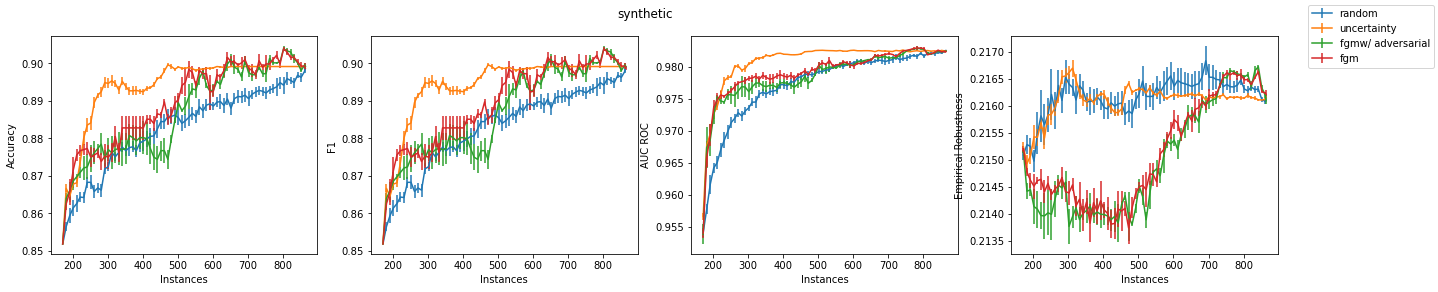

In [17]:
# Annoying hack so that the progressbars disapear as they're supposed to
from IPython.core.display import HTML, display
display(HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output pre:empty {
  display: none;
}
</style>
"""))

for dataset_name, dataset in tqdm(datasets.items(), desc="Dataset", leave=False):
    X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(*dataset(), labeled_size=0.1)
    
    fig, axes = plt.subplots(1, 4, figsize=(22,4))
    
    for method_name, method in tqdm(query_methods.items(), desc=f"Method", leave=False):
        if method_name == "fgm":
            for teach_advesarial in [True, False]:
                metrics = ProgressParallel(n_jobs=4, total=10 if method_name == "random" or method_name == "uncertainty" else 4, desc=f"Run", leave=False)(
                    delayed(
                        lambda X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, method: MyActiveLearner(metrics=[accuracy_score, f1_score, roc_auc_score, empirical_robustness]).active_learn2(X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, method, teach_advesarial=teach_advesarial)
                    )(X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, partial(method))
                    for _ in range(10 if method_name == "random" or method_name == "uncertainty" else 4)
                )
                metrics, stderr = metrics[0].average(metrics[1:])
                results[dataset_name][f"{method_name}-{teach_advesarial}"] = (metrics, stderr)
                metrics.to_csv(f"Experiments/experiment_robustness_{dataset_name}_method_{method_name}_{teach_advesarial}.csv")
                stderr.to_csv(f"Experiments/experiment_robustness_{dataset_name}_method_{method_name}_{teach_advesarial}_stderr.csv")

                for i, ax in enumerate(axes.flatten()):
                    teach_advesarial_str = "w/ adversarial" if teach_advesarial else ""
                    ax.errorbar(metrics['x'], metrics.iloc[:,1+i], yerr=stderr.iloc[:,1+i], label=f"{method_name}{teach_advesarial_str}" if i == 0 else "")
                    ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC", "Empirical Robustness"][i]); plt.suptitle(dataset_name)
                    
        else:
            teach_advesarial = False
            metrics = ProgressParallel(n_jobs=4, total=10 if method_name == "random" or method_name == "uncertainty" else 4, desc=f"Run", leave=False)(
                delayed(
                    lambda X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, method: MyActiveLearner(metrics=[accuracy_score, f1_score, roc_auc_score, empirical_robustness]).active_learn2(X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, method, teach_advesarial=teach_advesarial)
                )(X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, partial(method))
                for _ in range(10 if method_name == "random" or method_name == "uncertainty" else 4)
            )
            metrics, stderr = metrics[0].average(metrics[1:])
            results[dataset_name][method_name] = (metrics, stderr)
            metrics.to_csv(f"Experiments/experiment_robustness_{dataset_name}_method_{method_name}.csv")
            stderr.to_csv(f"Experiments/experiment_robustness_{dataset_name}_method_{method_name}_stderr.csv")

            for i, ax in enumerate(axes.flatten()):
                ax.errorbar(metrics['x'], metrics.iloc[:,1+i], yerr=stderr.iloc[:,1+i], label=f"{method_name}" if i == 0 else "")
                ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC", "Empirical Robustness"][i]); plt.suptitle(dataset_name)
                
    fig.legend()

## Runner test

In [6]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("car", lambda: lru_cache(car)())
    ],
    "dataset_mutators": {
        "none": (lambda *x: x),
    },
    "methods": [
        ("random", partial(random_batch, n_instances=10)),
        ("uncertainty", partial(batch.uncertainty_batch_sampling, n_instances=10)),
        ('fgm', partial(adversarial, Attack=FastGradientMethod, n_instances=10, teach_adversarial=False)),
        ('fgm with adversarial', partial(adversarial, Attack=FastGradientMethod, n_instances=10, teach_adversarial=True)),
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 0.1,
        "n_runs": 1
    }
}

In [ ]:
list(librun.Configurations(matrix))

In [4]:
import librun

In [7]:
reload(librun)
results = librun.run(matrix, force_cache=True)

c:\users\zac\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


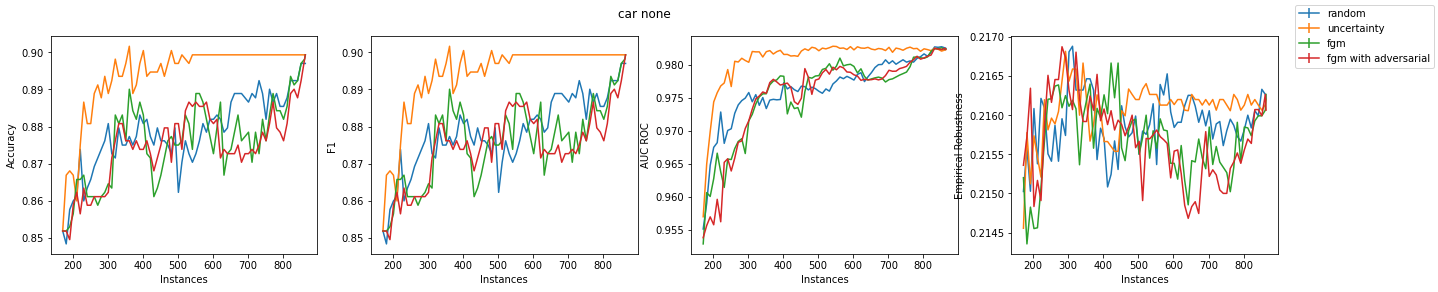

In [8]:
reload(librun)
librun.plot(results)

In [9]:
results[0][1]

,x,accuracy_score,f1_score,roc_auc_score,empirical_robustness,x_stderr,accuracy_score_stderr,f1_score_stderr,roc_auc_score_stderr,empirical_robustness_stderr
0,172.0,0.851852,0.851852,0.955139,0.215025,NaN,NaN,NaN,NaN,NaN
1,182.0,0.848380,0.848380,0.959032,0.215576,NaN,NaN,NaN,NaN,NaN
2,192.0,0.857639,0.857639,0.964801,0.215027,NaN,NaN,NaN,NaN,NaN
3,202.0,0.859954,0.859954,0.967524,0.216084,NaN,NaN,NaN,NaN,NaN
4,212.0,0.861111,0.861111,0.968228,0.215378,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
66,832.0,0.892361,0.892361,0.982746,0.216057,NaN,NaN,NaN,NaN,NaN
67,842.0,0.892361,0.892361,0.982688,0.215992,NaN,NaN,NaN,NaN,NaN
68,852.0,0.896991,0.896991,0.982773,0.216331,NaN,NaN,NaN,NaN,NaN
69,862.0,0.896991,0.896991,0.982588,0.216265,NaN,NaN,NaN,NaN,NaN
